In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jul 14 10:37:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 21%   35C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 1e-3, 317)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 11.96 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 11.58 s
Constructing 160000 event dataset took 3.855 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.151 s
Constructing 9984 event dataset took 0.1228 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelE()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/0acd115227d54971a1005c866cc827db/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 18.5 parameter layers to update in the current model, 18.5 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_E(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3a): Conv1d(25, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(9, eps=1e-05, momentu

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


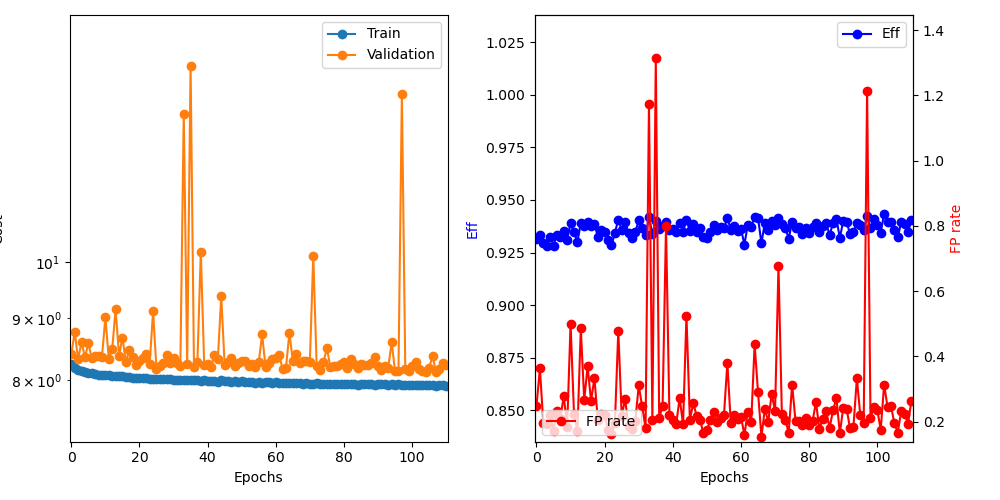

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
print('for model: ', model)   
run_name = 'ACNN E'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  All_CNN6Layer_E(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3a): Conv1d(25, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(9, eps=1e

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 317: train=8.25139, val=8.40359, took 40.279 s
  Validation Found 50770 of 54504, added 2483 (eff 93.15%) (0.249 FP/event)


Epoch 318: train=8.18801, val=8.76622, took 39.237 s
  Validation Found 50866 of 54504, added 3620 (eff 93.33%) (0.363 FP/event)


Epoch 319: train=8.16358, val=8.32472, took 39.261 s
  Validation Found 50671 of 54504, added 1950 (eff 92.97%) (0.195 FP/event)


Epoch 320: train=8.14885, val=8.60296, took 39.266 s
  Validation Found 50573 of 54504, added 1910 (eff 92.79%) (0.191 FP/event)


Epoch 321: train=8.1349, val=8.35743, took 39.348 s
  Validation Found 50823 of 54504, added 2196 (eff 93.25%) (0.22 FP/event)


Epoch 322: train=8.10833, val=8.57952, took 39.461 s
  Validation Found 50596 of 54504, added 1719 (eff 92.83%) (0.172 FP/event)


Epoch 323: train=8.1113, val=8.34323, took 39.73 s
  Validation Found 50882 of 54504, added 2323 (eff 93.35%) (0.233 FP/event)


Epoch 324: train=8.09925, val=8.37196, took 39.5 s
  Validation Found 50814 of 54504, added 2105 (eff 93.23%) (0.211 FP/event)


Epoch 325: train=8.08838, val=8.37971, took 39.326 s
  Validation Found 50974 of 54504, added 2776 (eff 93.52%) (0.278 FP/event)


Epoch 326: train=8.08731, val=8.36339, took 39.19 s
  Validation Found 50742 of 54504, added 1837 (eff 93.10%) (0.184 FP/event)


Epoch 327: train=8.0805, val=9.01163, took 40.306 s
  Validation Found 51176 of 54504, added 4995 (eff 93.89%) (0.5 FP/event)


Epoch 328: train=8.08243, val=8.33192, took 39.945 s
  Validation Found 50955 of 54504, added 2241 (eff 93.49%) (0.224 FP/event)


Epoch 329: train=8.06462, val=8.48723, took 40.06 s
  Validation Found 50678 of 54504, added 1700 (eff 92.98%) (0.17 FP/event)


Epoch 330: train=8.06182, val=9.15037, took 40.047 s
  Validation Found 51189 of 54504, added 4845 (eff 93.92%) (0.485 FP/event)


Epoch 331: train=8.06426, val=8.38317, took 39.748 s
  Validation Found 51097 of 54504, added 2655 (eff 93.75%) (0.266 FP/event)


Epoch 332: train=8.0619, val=8.67274, took 39.407 s
  Validation Found 51200 of 54504, added 3686 (eff 93.94%) (0.369 FP/event)


Epoch 333: train=8.05097, val=8.28265, took 39.606 s
  Validation Found 51095 of 54504, added 2632 (eff 93.75%) (0.264 FP/event)


Epoch 334: train=8.05227, val=8.46877, took 40.386 s
  Validation Found 51158 of 54504, added 3319 (eff 93.86%) (0.332 FP/event)


Epoch 335: train=8.04058, val=8.35351, took 40.215 s
  Validation Found 50818 of 54504, added 2047 (eff 93.24%) (0.205 FP/event)


Epoch 336: train=8.03885, val=8.23845, took 39.335 s
  Validation Found 51006 of 54504, added 2236 (eff 93.58%) (0.224 FP/event)


Epoch 337: train=8.03836, val=8.29785, took 39.036 s
  Validation Found 50951 of 54504, added 2201 (eff 93.48%) (0.22 FP/event)


Epoch 338: train=8.03753, val=8.3416, took 39.126 s
  Validation Found 50743 of 54504, added 1750 (eff 93.10%) (0.175 FP/event)


Epoch 339: train=8.03229, val=8.41192, took 39.494 s
  Validation Found 50605 of 54504, added 1606 (eff 92.85%) (0.161 FP/event)


Epoch 340: train=8.02816, val=8.25638, took 39.195 s
  Validation Found 50926 of 54504, added 1937 (eff 93.44%) (0.194 FP/event)


Epoch 341: train=8.0237, val=9.11661, took 39.08 s
  Validation Found 51266 of 54504, added 4777 (eff 94.06%) (0.478 FP/event)


Epoch 342: train=8.02503, val=8.16619, took 39.042 s
  Validation Found 51006 of 54504, added 2161 (eff 93.58%) (0.216 FP/event)


Epoch 343: train=8.01671, val=8.22468, took 39.077 s
  Validation Found 51218 of 54504, added 2683 (eff 93.97%) (0.269 FP/event)


Epoch 344: train=8.0235, val=8.26907, took 39.06 s
  Validation Found 50922 of 54504, added 1853 (eff 93.43%) (0.186 FP/event)


Epoch 345: train=8.02206, val=8.38591, took 39.027 s
  Validation Found 50786 of 54504, added 1783 (eff 93.18%) (0.179 FP/event)


Epoch 346: train=8.01395, val=8.27096, took 38.991 s
  Validation Found 50957 of 54504, added 2026 (eff 93.49%) (0.203 FP/event)


Epoch 347: train=8.01098, val=8.34331, took 38.999 s
  Validation Found 51246 of 54504, added 3103 (eff 94.02%) (0.311 FP/event)


Epoch 348: train=8.01273, val=8.26782, took 39.976 s
  Validation Found 51063 of 54504, added 2463 (eff 93.69%) (0.247 FP/event)


Epoch 349: train=8.01088, val=8.22188, took 39.028 s
  Validation Found 50868 of 54504, added 1799 (eff 93.33%) (0.18 FP/event)


Epoch 350: train=8.01274, val=13.2364, took 39.035 s
  Validation Found 51335 of 54504, added 11725 (eff 94.19%) (1.17 FP/event)


Epoch 351: train=7.99926, val=8.25201, took 39.029 s
  Validation Found 50901 of 54504, added 2031 (eff 93.39%) (0.203 FP/event)


Epoch 352: train=8.00306, val=14.4917, took 39.784 s
  Validation Found 51235 of 54504, added 13127 (eff 94.00%) (1.31 FP/event)


Epoch 353: train=8.01037, val=8.21032, took 39.267 s
  Validation Found 51020 of 54504, added 2095 (eff 93.61%) (0.21 FP/event)


Epoch 354: train=7.99995, val=8.27804, took 40.026 s
  Validation Found 51113 of 54504, added 2477 (eff 93.78%) (0.248 FP/event)


Epoch 355: train=7.99464, val=10.1924, took 39.02 s
  Validation Found 51214 of 54504, added 7983 (eff 93.96%) (0.799 FP/event)


Epoch 356: train=8.00362, val=8.24082, took 39.031 s
  Validation Found 50997 of 54504, added 2190 (eff 93.57%) (0.219 FP/event)


Epoch 357: train=7.98905, val=8.25189, took 39.084 s
  Validation Found 51024 of 54504, added 2034 (eff 93.62%) (0.204 FP/event)


Epoch 358: train=7.98595, val=8.19795, took 39.032 s
  Validation Found 50960 of 54504, added 1927 (eff 93.50%) (0.193 FP/event)


Epoch 359: train=7.99184, val=8.3878, took 39.039 s
  Validation Found 51189 of 54504, added 2715 (eff 93.92%) (0.272 FP/event)


Epoch 360: train=7.98298, val=8.32269, took 40.106 s
  Validation Found 50952 of 54504, added 1914 (eff 93.48%) (0.192 FP/event)


Epoch 361: train=8.00048, val=9.37552, took 39.236 s
  Validation Found 51256 of 54504, added 5234 (eff 94.04%) (0.524 FP/event)


Epoch 362: train=7.99679, val=8.23512, took 38.986 s
  Validation Found 50968 of 54504, added 2058 (eff 93.51%) (0.206 FP/event)


Epoch 363: train=7.99007, val=8.27568, took 39.008 s
  Validation Found 51143 of 54504, added 2549 (eff 93.83%) (0.255 FP/event)


Epoch 364: train=7.97875, val=8.34257, took 39.364 s
  Validation Found 50939 of 54504, added 2174 (eff 93.46%) (0.218 FP/event)


Epoch 365: train=7.98983, val=8.21344, took 39.419 s
  Validation Found 51045 of 54504, added 2032 (eff 93.65%) (0.204 FP/event)


Epoch 366: train=7.97581, val=8.26926, took 39.206 s
  Validation Found 50812 of 54504, added 1634 (eff 93.23%) (0.164 FP/event)


Epoch 367: train=7.98655, val=8.30188, took 39.779 s
  Validation Found 50780 of 54504, added 1726 (eff 93.17%) (0.173 FP/event)


Epoch 368: train=7.97279, val=8.29501, took 39.688 s
  Validation Found 50942 of 54504, added 2051 (eff 93.46%) (0.205 FP/event)


Epoch 369: train=7.97117, val=8.22213, took 40.042 s
  Validation Found 51128 of 54504, added 2283 (eff 93.81%) (0.229 FP/event)


Epoch 370: train=7.97312, val=8.25528, took 39.021 s
  Validation Found 50989 of 54504, added 1972 (eff 93.55%) (0.197 FP/event)


Epoch 371: train=7.96504, val=8.2031, took 39.004 s
  Validation Found 51067 of 54504, added 2117 (eff 93.69%) (0.212 FP/event)


Epoch 372: train=7.97612, val=8.28476, took 38.989 s
  Validation Found 51040 of 54504, added 2185 (eff 93.64%) (0.219 FP/event)


Epoch 373: train=7.96374, val=8.72502, took 38.927 s
  Validation Found 51321 of 54504, added 3793 (eff 94.16%) (0.38 FP/event)


Epoch 374: train=7.98118, val=8.19862, took 38.908 s
  Validation Found 50997 of 54504, added 1955 (eff 93.57%) (0.196 FP/event)


Epoch 375: train=7.98076, val=8.27122, took 38.948 s
  Validation Found 51104 of 54504, added 2191 (eff 93.76%) (0.219 FP/event)


Epoch 376: train=7.96539, val=8.334, took 38.97 s
  Validation Found 50978 of 54504, added 2087 (eff 93.53%) (0.209 FP/event)


Epoch 377: train=7.97226, val=8.33973, took 38.993 s
  Validation Found 51034 of 54504, added 2145 (eff 93.63%) (0.215 FP/event)


Epoch 378: train=7.96097, val=8.39444, took 39.436 s
  Validation Found 50618 of 54504, added 1588 (eff 92.87%) (0.159 FP/event)


Epoch 379: train=7.96324, val=8.1754, took 39.078 s
  Validation Found 51139 of 54504, added 2299 (eff 93.83%) (0.23 FP/event)


Epoch 380: train=7.96385, val=8.19635, took 38.902 s
  Validation Found 51065 of 54504, added 1976 (eff 93.69%) (0.198 FP/event)


Epoch 381: train=7.95603, val=8.75297, took 38.898 s
  Validation Found 51344 of 54504, added 4355 (eff 94.20%) (0.436 FP/event)


Epoch 382: train=7.96371, val=8.29491, took 39.994 s
  Validation Found 51312 of 54504, added 2900 (eff 94.14%) (0.29 FP/event)


Epoch 383: train=7.95507, val=8.41531, took 39.646 s
  Validation Found 50657 of 54504, added 1532 (eff 92.94%) (0.153 FP/event)


Epoch 384: train=7.95634, val=8.26673, took 39.073 s
  Validation Found 51188 of 54504, added 2387 (eff 93.92%) (0.239 FP/event)


Epoch 385: train=7.95238, val=8.29577, took 39.375 s
  Validation Found 50988 of 54504, added 1996 (eff 93.55%) (0.2 FP/event)


Epoch 386: train=7.95589, val=8.29656, took 39.365 s
  Validation Found 51231 of 54504, added 2843 (eff 93.99%) (0.285 FP/event)


Epoch 387: train=7.95247, val=8.28954, took 39.375 s
  Validation Found 51127 of 54504, added 2320 (eff 93.80%) (0.232 FP/event)


Epoch 388: train=7.94789, val=10.123, took 39.375 s
  Validation Found 51317 of 54504, added 6764 (eff 94.15%) (0.677 FP/event)


Epoch 389: train=7.95522, val=8.21813, took 39.502 s
  Validation Found 51160 of 54504, added 2214 (eff 93.86%) (0.222 FP/event)


Epoch 390: train=7.94612, val=8.16146, took 39.191 s
  Validation Found 51056 of 54504, added 2056 (eff 93.67%) (0.206 FP/event)


Epoch 391: train=7.95052, val=8.27689, took 39.448 s
  Validation Found 50776 of 54504, added 1649 (eff 93.16%) (0.165 FP/event)


Epoch 392: train=7.94743, val=8.50456, took 39.209 s
  Validation Found 51203 of 54504, added 3128 (eff 93.94%) (0.313 FP/event)


Epoch 393: train=7.94357, val=8.20306, took 38.987 s
  Validation Found 51041 of 54504, added 2013 (eff 93.65%) (0.202 FP/event)


Epoch 394: train=7.94184, val=8.22362, took 39.199 s
  Validation Found 51071 of 54504, added 2014 (eff 93.70%) (0.202 FP/event)


Epoch 395: train=7.95076, val=8.21394, took 39.022 s
  Validation Found 50891 of 54504, added 1895 (eff 93.37%) (0.19 FP/event)


Epoch 396: train=7.95118, val=8.258, took 39.032 s
  Validation Found 51063 of 54504, added 2115 (eff 93.69%) (0.212 FP/event)


Epoch 397: train=7.95303, val=8.28133, took 38.9 s
  Validation Found 50913 of 54504, added 1897 (eff 93.41%) (0.19 FP/event)


Epoch 398: train=7.94041, val=8.19486, took 38.912 s
  Validation Found 51070 of 54504, added 2006 (eff 93.70%) (0.201 FP/event)


Epoch 399: train=7.94973, val=8.32954, took 38.896 s
  Validation Found 51180 of 54504, added 2589 (eff 93.90%) (0.259 FP/event)


Epoch 400: train=7.93993, val=8.25062, took 38.883 s
  Validation Found 50937 of 54504, added 1776 (eff 93.46%) (0.178 FP/event)


Epoch 401: train=7.93723, val=8.1861, took 38.9 s
  Validation Found 51092 of 54504, added 2079 (eff 93.74%) (0.208 FP/event)


Epoch 402: train=7.94396, val=8.24551, took 39.287 s
  Validation Found 51177 of 54504, added 2317 (eff 93.90%) (0.232 FP/event)


Epoch 403: train=7.93961, val=8.23756, took 39.17 s
  Validation Found 50868 of 54504, added 1799 (eff 93.33%) (0.18 FP/event)


Epoch 404: train=7.94507, val=8.23067, took 39.031 s
  Validation Found 51178 of 54504, added 2340 (eff 93.90%) (0.234 FP/event)


Epoch 405: train=7.94247, val=8.26969, took 39.661 s
  Validation Found 51294 of 54504, added 2713 (eff 94.11%) (0.272 FP/event)


Epoch 406: train=7.93445, val=8.36839, took 40.189 s
  Validation Found 50796 of 54504, added 1640 (eff 93.20%) (0.164 FP/event)


Epoch 407: train=7.941, val=8.22352, took 38.892 s
  Validation Found 51230 of 54504, added 2411 (eff 93.99%) (0.241 FP/event)


Epoch 408: train=7.93964, val=8.15102, took 38.872 s
  Validation Found 51206 of 54504, added 2382 (eff 93.95%) (0.239 FP/event)


Epoch 409: train=7.94589, val=8.21288, took 39.018 s
  Validation Found 50897 of 54504, added 1790 (eff 93.38%) (0.179 FP/event)


Epoch 410: train=7.93779, val=8.19565, took 39.108 s
  Validation Found 50955 of 54504, added 1840 (eff 93.49%) (0.184 FP/event)


Epoch 411: train=7.94229, val=8.59417, took 38.982 s
  Validation Found 51171 of 54504, added 3320 (eff 93.88%) (0.332 FP/event)


Epoch 412: train=7.9359, val=8.13992, took 40.118 s
  Validation Found 51124 of 54504, added 2201 (eff 93.80%) (0.22 FP/event)


Epoch 413: train=7.94333, val=8.14819, took 39.929 s
  Validation Found 50994 of 54504, added 1942 (eff 93.56%) (0.194 FP/event)


Epoch 414: train=7.93089, val=13.7372, took 39.927 s
  Validation Found 51361 of 54504, added 12123 (eff 94.23%) (1.21 FP/event)


Epoch 415: train=7.93023, val=8.17838, took 39.919 s
  Validation Found 51054 of 54504, added 2099 (eff 93.67%) (0.21 FP/event)


Epoch 416: train=7.93513, val=8.1461, took 39.925 s
  Validation Found 51280 of 54504, added 2454 (eff 94.08%) (0.246 FP/event)


Epoch 417: train=7.93131, val=8.21359, took 39.927 s
  Validation Found 51139 of 54504, added 2351 (eff 93.83%) (0.235 FP/event)


Epoch 418: train=7.92894, val=8.28375, took 39.7 s
  Validation Found 50929 of 54504, added 1742 (eff 93.44%) (0.174 FP/event)


Epoch 419: train=7.92601, val=8.16893, took 39.341 s
  Validation Found 51425 of 54504, added 3128 (eff 94.35%) (0.313 FP/event)


Epoch 420: train=7.92553, val=8.14245, took 38.905 s
  Validation Found 51217 of 54504, added 2442 (eff 93.97%) (0.245 FP/event)


Epoch 421: train=7.93236, val=8.12996, took 38.913 s
  Validation Found 51201 of 54504, added 2477 (eff 93.94%) (0.248 FP/event)


Epoch 422: train=7.92886, val=8.19174, took 38.909 s
  Validation Found 51008 of 54504, added 1943 (eff 93.59%) (0.195 FP/event)


Epoch 423: train=7.92794, val=8.37857, took 39.064 s
  Validation Found 50811 of 54504, added 1661 (eff 93.22%) (0.166 FP/event)


Epoch 424: train=7.91874, val=8.12636, took 39.196 s
  Validation Found 51195 of 54504, added 2307 (eff 93.93%) (0.231 FP/event)


Epoch 425: train=7.92771, val=8.17632, took 39.267 s
  Validation Found 51144 of 54504, added 2237 (eff 93.84%) (0.224 FP/event)


Epoch 426: train=7.93544, val=8.26566, took 39.273 s
  Validation Found 50936 of 54504, added 1922 (eff 93.45%) (0.192 FP/event)


Epoch 427: train=7.91736, val=8.22898, took 38.951 s
  Validation Found 51248 of 54504, added 2633 (eff 94.03%) (0.264 FP/event)


In [ ]:
##quit()